In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt
# !pip install geopandas==0.14.4

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Read GSC Gravity data

In [2]:
df = pd.read_csv("../data/Canada_Gravity_2018.csv", comment='/')

## Access columns in the table

In [3]:
# Pull out Longitude and Latitude
xy = df[['X', 'Y']].values

Text(0, 0.5, 'Latitude')

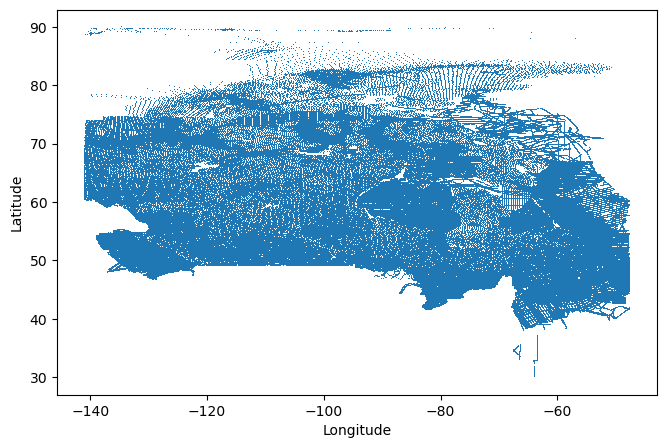

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(xy[:,0], xy[:,1], ',')
ax.set_aspect(1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.set_title(day)

## `groupby` the data with a column `DAY`

In [5]:
df_grouped_day = df.groupby('DAY')

In [6]:
# get unique days
days = list(df_grouped_day.groups.keys())

In [7]:
print (f"There are {len(days)} unique days.")

There are 6606 unique days.


In [8]:
# Explort gravity data obtained at'01-APR-1965'
day = days[0]
df_grouped_day.get_group(day)[['X', 'Y', 'ADJG', 'DAY']].to_csv('fime_demo.csv', index=False)

## Put together an interative widget

In [9]:
from ipywidgets import widgets, interact
def foo(day):
    df_tmp_group = df_grouped_day.get_group(day)[['X', 'Y', 'ADJG', 'DAY']]
    xy_tmp = df_tmp_group[['X', 'Y']].values
    
    
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    ax.plot(xy[:,0], xy[:,1], ',')
    ax.plot(xy_tmp[:,0], xy_tmp[:,1], 'ro')
    ax.set_aspect(1)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(day)
interact(foo, day=widgets.Select(options=days))

interactive(children=(Select(description='day', options=('01-APR-1965', '01-APR-1969', '01-APR-1970', '01-APR-…

<function __main__.foo(day)>

In [10]:
number_of_points = xy.shape[0]
number_of_points / 1e5

7.16957

## Read `geojson` file containing the boundary of Canadian shield

In [11]:
gdf = gpd.read_file("../data/canadian-shield_1266.geojson")

<Axes: >

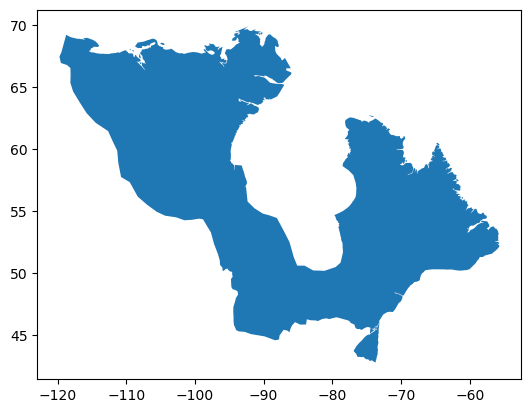

In [12]:
#plot Canadian shield as polygon
gdf.plot()

<Axes: >

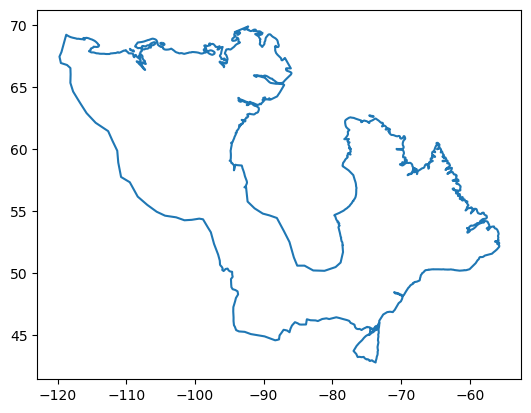

In [13]:
#plot the boundary
gdf.boundary.plot()

## Plot other columns in the dataframe

In [14]:
from ipywidgets import widgets, interact
names = list(df.keys() )

### Filter out some locations with unreasonable values

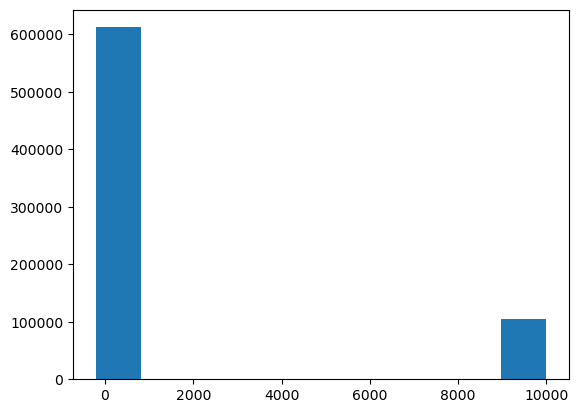

In [15]:
out = plt.hist(df['BOUGUER'].values)

In [16]:
inds = df['BOUGUER'].values<2000.

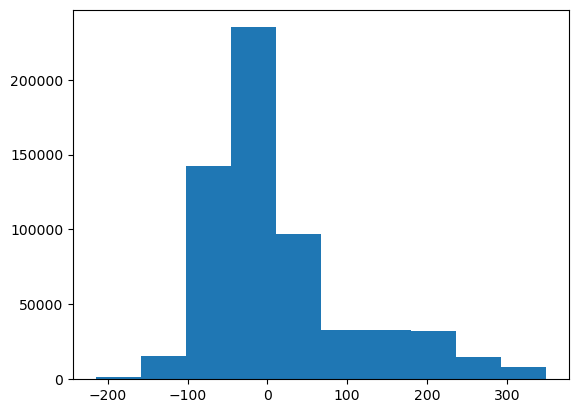

In [17]:
out = plt.hist(df['BOUGUER'].values[df['BOUGUER'].values<2000.])

In [18]:
def foo(name, n_skip):
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    out = ax.scatter(
        xy[inds,0][::n_skip], xy[inds,1][::n_skip], s=1, c=df[name].values[inds][::n_skip], 
        cmap='turbo', 
        # vmin=-215.6, vmax=242.6
    )
    gdf.boundary.plot(ax=ax, color='red')
    plt.colorbar(out)
    ax.set_aspect(1)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(name)
    
interact(foo, name=widgets.Select(options=names, value='BOUGUER'), n_skip=widgets.IntSlider(min=1, max=20, step=1, value=5))

interactive(children=(Select(description='name', index=4, options=('X', 'Y', 'ADJG', 'B_ERR', 'BOUGUER', 'COOR…

<function __main__.foo(name, n_skip)>

In [19]:
def get_normal_gravity(phi_degree, e2=0.00669438002290, k=0.001931851353, gamma_e=978032.67715):
    phi = np.deg2rad(phi_degree)
    sin2 = np.sin(phi)**2
    gamma_phi = gamma_e * (1+k*sin2) / (np.sqrt(1-e2*sin2))
    return gamma_phi

$$\triangle g_{F} = g_{obs}-g_{normal}+0.3086h$$

In [20]:
free_air_correction = get_normal_gravity(xy[:,1])  - 0.3086 * df['ELEV'].values

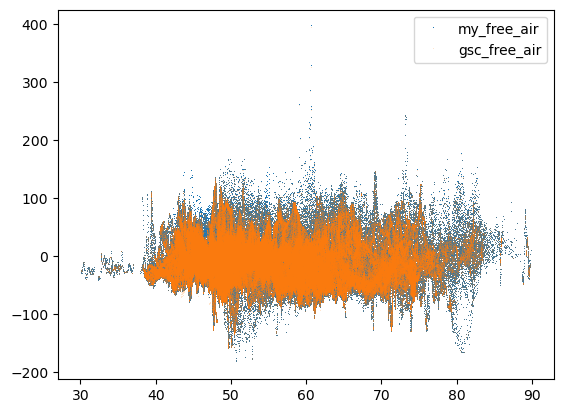

In [21]:
plt.plot(xy[:,1], df['ADJG'].values-free_air_correction, ',', label='my_free_air')
plt.plot(xy[:,1], df['FREEAIR'].values, ',', alpha=0.2, label='gsc_free_air')
plt.legend()

In [22]:
free_air_anomaly = df['ADJG'].values-free_air_correction

Text(642.5449797567387, 0.5, 'Latitude')

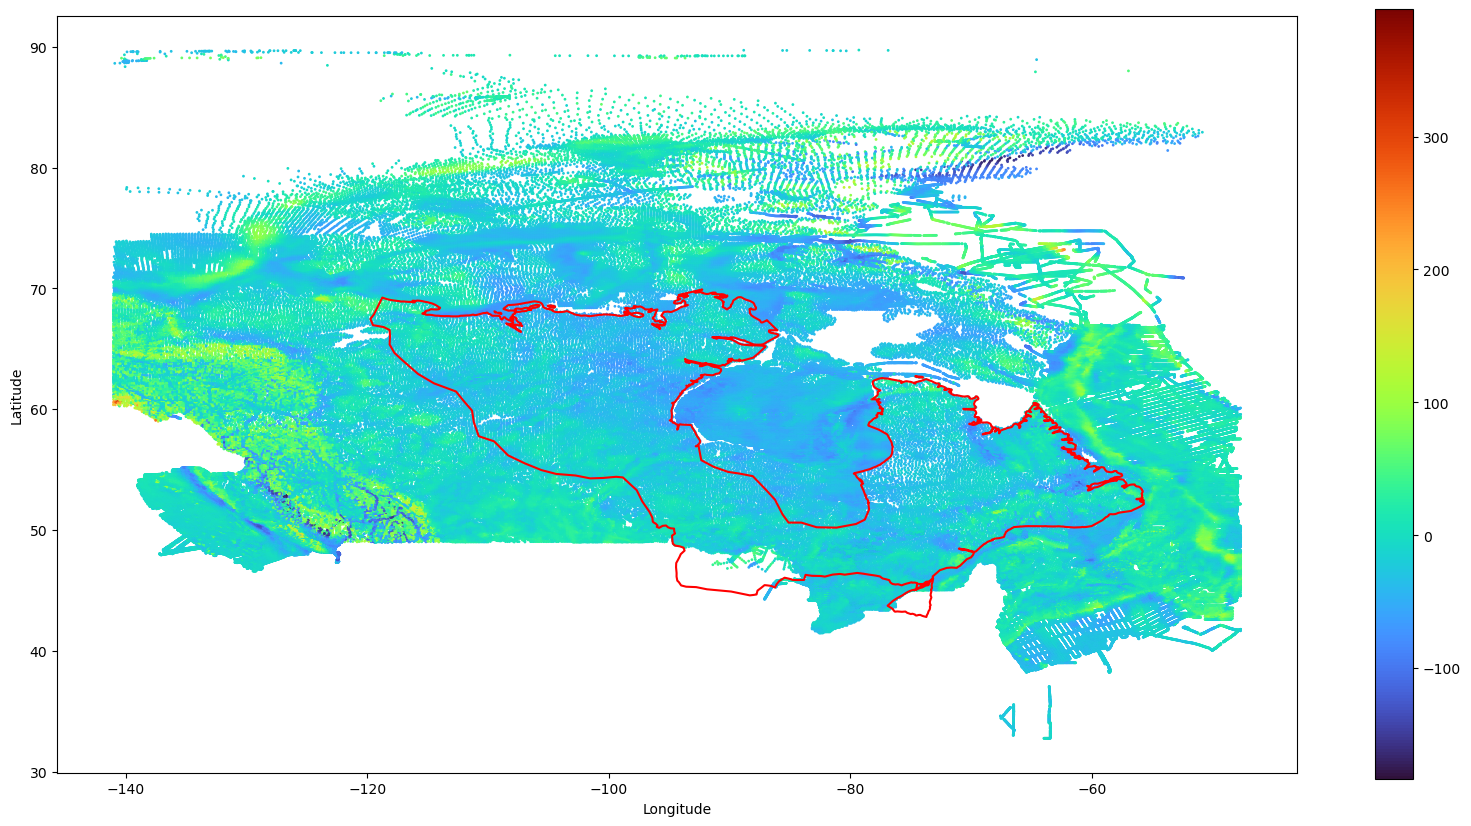

In [23]:
n_skip = 1
fig, ax = plt.subplots(1,1, figsize=(20, 10))
out = ax.scatter(
    xy[inds,0][::n_skip], xy[inds,1][::n_skip], s=1, c=free_air_anomaly[inds][::n_skip], 
    cmap='turbo', 
    # vmin=-215.6, vmax=242.6
)
gdf.boundary.plot(ax=ax, color='red')
plt.colorbar(out)
ax.set_aspect(1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [24]:
free_air_anomaly

array([-19.41088936, -16.21220051, -15.11383777, ..., -30.63035053,
        55.50025834,  25.50594081])

# Logical next step?

- Calculiate Bouguer Anomaly?


In [25]:
# !pip install verde

In [26]:
points = gpd.points_from_xy(xy[:,0], xy[:,1], crs=4326)
gdf_points = gpd.GeoDataFrame(data={}, geometry=points)

In [27]:
gdf_points_clipped = gdf_points.clip(gdf)

<Axes: >

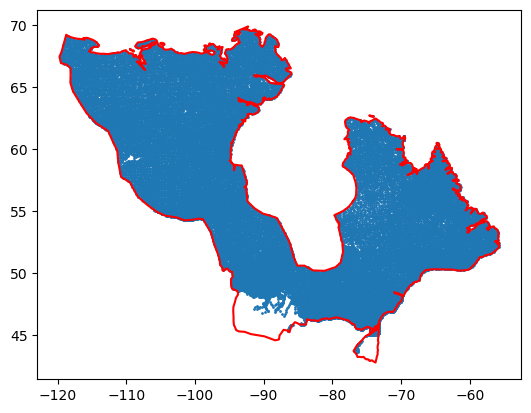

In [28]:
fig, ax = plt.subplots(1,1)
gdf_points_clipped.plot(markersize=1, ax=ax)
gdf.boundary.plot(ax=ax, color='r')

In [29]:
from scipy.spatial import cKDTree as KDTree
from verde import distance_mask
def inverse_distance_interpolation(
    xy, values, 
    dx=100, dy=100, x_pad=1000, y_pad=1000,
    power=0, epsilon=None, k_nearest_points=20, 
    max_distance=4000.,
):
    """
        Evaluating 2D inverse distance weighting interpolation
        for given (x, y) points and values.
        
        Inverse distance weight, w, can be written as:
            w = 1/(distance+epsilon)**power
        
        Parameters
        ----------
        xy : array_like
            Input array including (x, y) locations; (n_locations, 2)
        values: array_like
            Input array including values defined at (x, y) locations; (n_locations, )
        dx : int 
            Size of the uniform grid in x-direction
        dy : int 
            Size of the uniform grid in y-direction
        x_pad : float 
            Length of padding in x-direction
        y_pad : float 
            Length of padding in y-direction
        power: float
            Exponent used when evaluating inverse distance weight. 
        epsilon: float
            A floor value used when evaluating inverse distance weight. 
        k_nearest_points: int 
            k-nearest-point used when evaluating inverse distance weight.  
        max_distance: float
            A separation distance used to maks grid points away from the (x, y) locations.
        
        Returns        
        -------
        

    """
    xmin, xmax = xy[:,0].min()-x_pad, xy[:,0].max()+x_pad
    ymin, ymax = xy[:,1].min()-y_pad, xy[:,1].max()+y_pad

    nx = int((xmax-xmin) / dx)
    ny = int((ymax-ymin) / dy)
    hx = np.ones(nx) * dx
    hy = np.ones(ny) * dy
    x = np.arange(nx)*dx + xmin
    y = np.arange(ny)*dy + ymin
    X, Y = np.meshgrid(x, y)

    tree = KDTree(xy)

    d, inds_idw = tree.query(np.c_[X.flatten(), Y.flatten()], k=int(k_nearest_points))
    if epsilon is None:
        epsilon = np.min([dx, dy])
    w = 1.0 / ((d+epsilon) ** power)
    values_idw = (np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1))
    mask_inds = ~distance_mask(
        (xy[:,0], xy[:,1]), maxdist=max_distance, coordinates=(X.flatten(), Y.flatten())
    )
    values_idw[mask_inds] = np.nan
    values_idw = values_idw.reshape(X.shape)
    return x, y, values_idw

In [30]:
dx = 0.5
dy = 0.5
x, y, values_idw = inverse_distance_interpolation(xy, free_air_anomaly, x_pad=1, y_pad=1, dx=0.5, dy=0.5, max_distance=2.)
xmin = x.min()
ymin = y.min()
crs = int(4326)
nx = len(x)
ny = len(y)

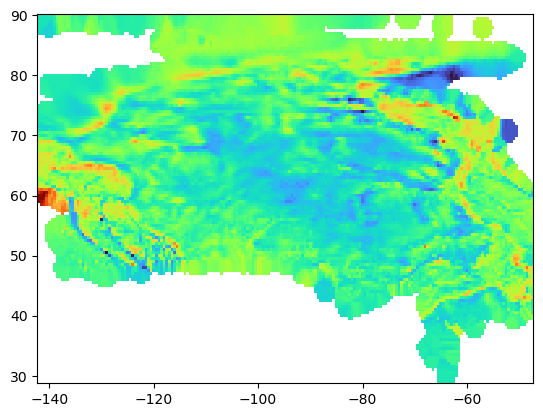

In [31]:
plt.pcolormesh(x, y, values_idw, cmap='turbo')

In [32]:
# !pip install emrecharge
from emrecharge.gis import export_to_tif

In [38]:
filename = './test'
export_to_tif(values_idw, dx, dy, xmin, ymin, int(4326), f'{filename}.tif')